# Chapter 9. 비지도 학습

* 비지도 학습에는 clustering, demensionality reduction, anomaly detection 등이 있다.

* 여기서는 clustering을 다룬다.

## 9.1 2차원 입력 데이터

* 2차원 입력 데이터 X를 사용하지만 비지도 학습이기 때문에 클래스 데이터 T는 사용하지 않는다.

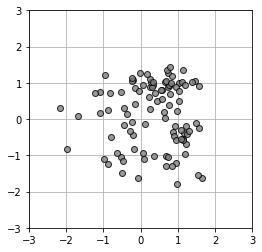

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터 생성
np.random.seed(1)
N = 100
K = 3
T3 = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ['cornflowerblue', 'black', 'white']
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 누적 확률
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k]
                   + Mu[T3[n, :] == 1, k])


# 데이터를 그리기
def show_data(x):
    plt.plot(x[:, 0], x[:, 1], linestyle='none',
             marker='o', markersize=6,
             markeredgecolor='black', color='gray', alpha=0.8)
    plt.grid(True)


# 메인
plt.figure(1, figsize=(4, 4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez('data_ch9.npz', X=X, X_range0=X_range0,
         X_range1=X_range1)

* 데이터를 색깔 구분없이 나타낸다.
* 잘 살펴보면 분포의 경향을 파악할 수 있다.
* 이러한 데이터의 분포의 모양을 cluster라고 한다.
* 같은 cluster내에는 동일한 class(or label)을 붙이고, 다른 cluster끼리는 다른 class를 할당한다.
    * class는 단순한 label, cluster는 분포의 특징을 나타내는 용어이다.
    * 하지만 동의어로 사용되는 경우도 있다.

## 9.2 K-means 기법

### 9.2.1 K-means 기법의 개요

<div>
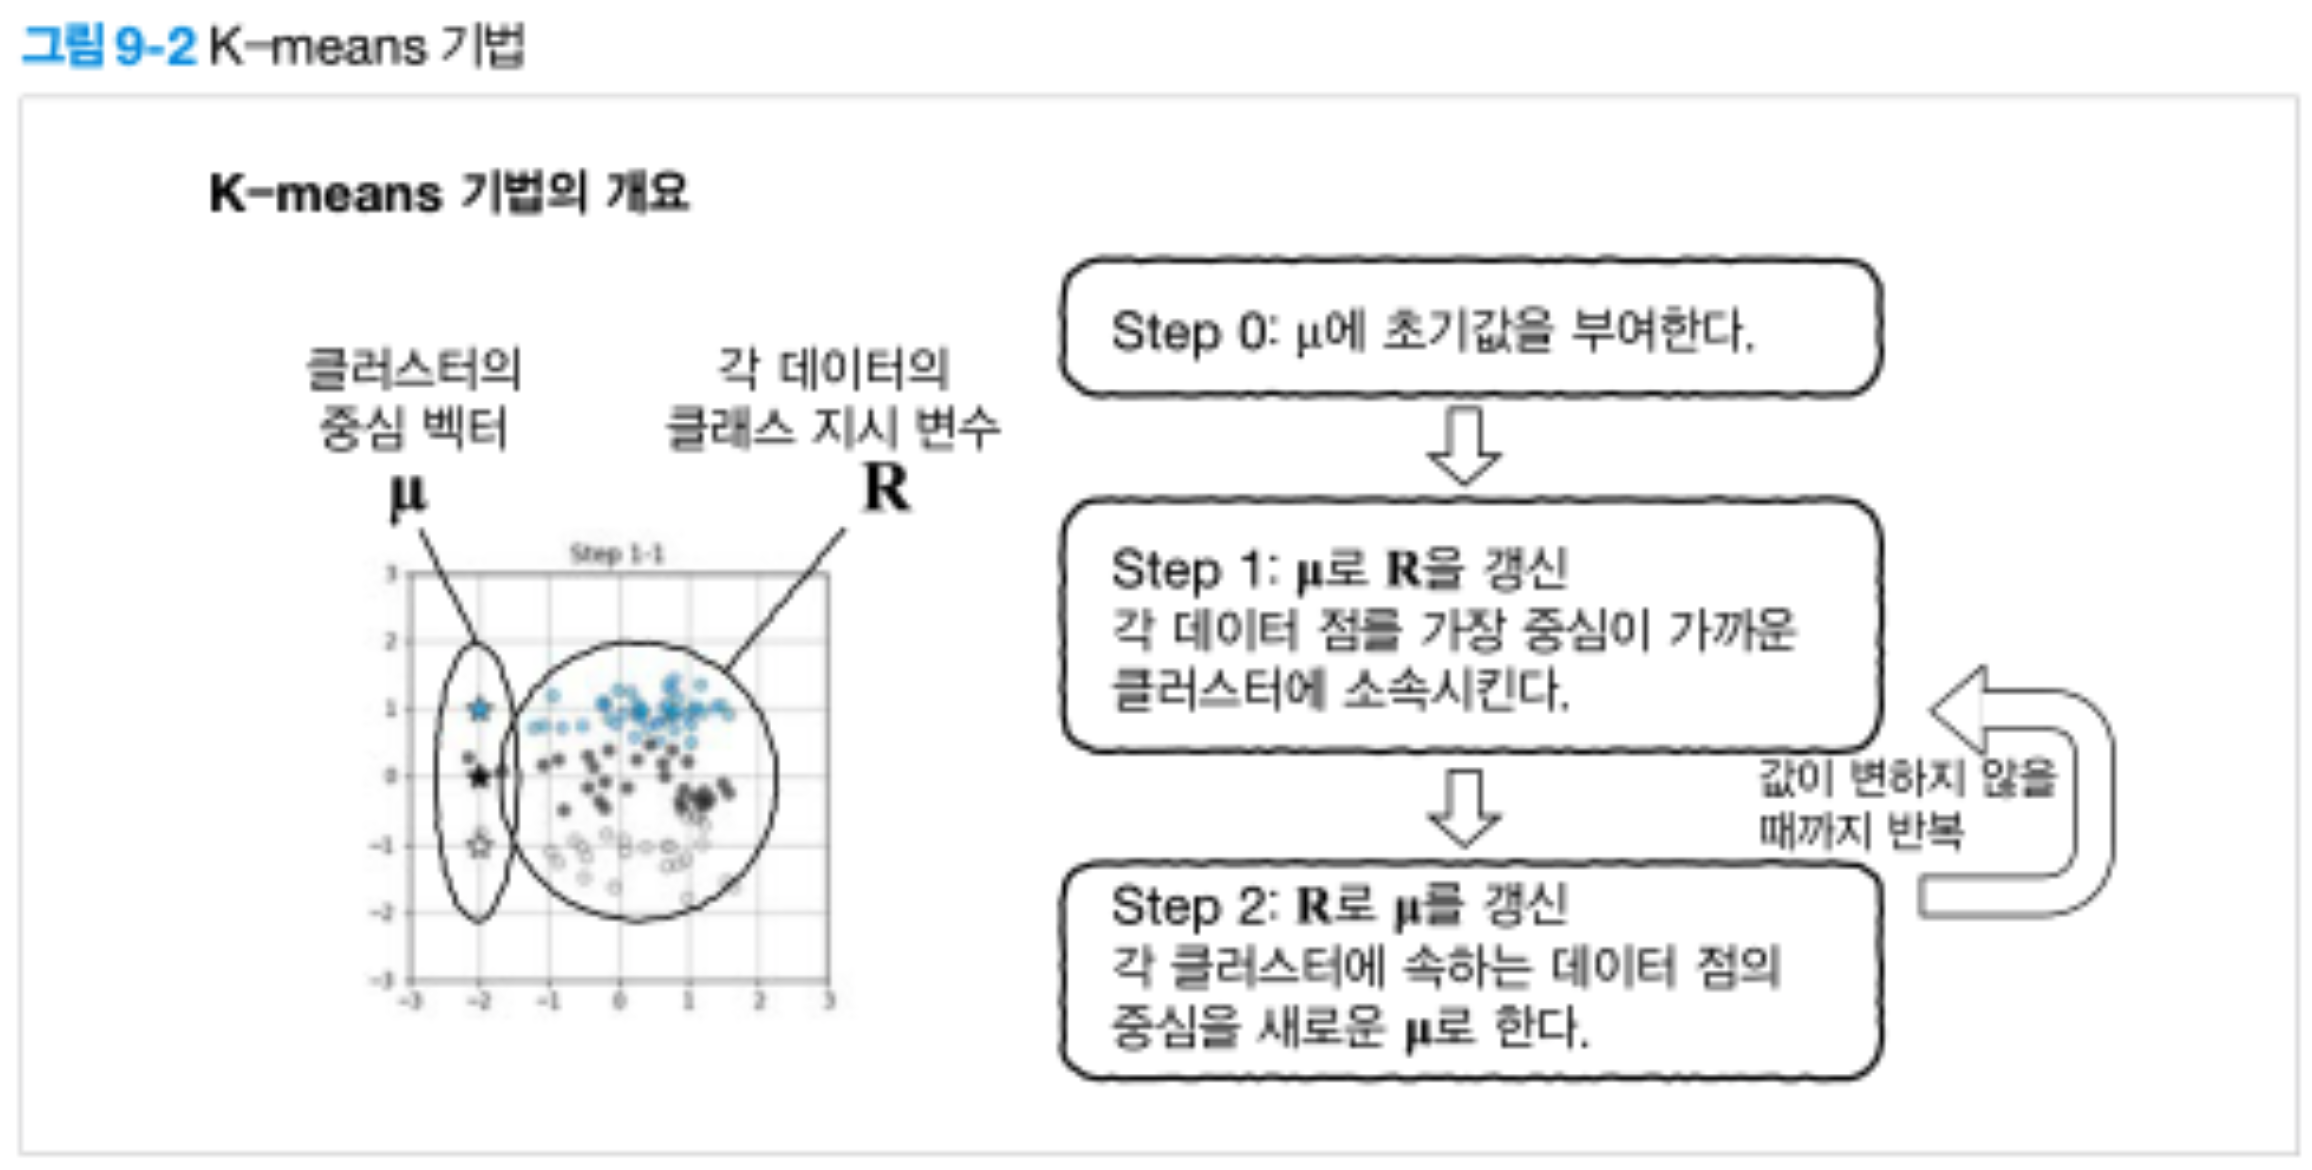
</div>

* K-means에서는 미리 분할할 cluster의 개수 K를 결정해야 한다.
    * 이 예제에서는 K = 3인 경우를 다룬다.

* K-means 기법에는 두 변수를 사용한다.
    * $\mu$ : cluster의 중심 벡터, cluster의 중심 위치를 나타낸다.
    * R : class 지시 변수, 각 데이터 점이 어떤 class에 속하는지 나타낸다.
    
* K-means algorithm
    * Step 0. $\mu$를 적절한 값으로 초기화한다.
    * Step 1. $\mu$를 통해 R을 갱신한다.
    * Step 2. R을 통해 $\mu$를 갱신한다.
    * 이후 Step 1과 Step 2를 $\mu$와 R이 바뀌지 않을 때까지 반복한다.

### 9.2.2 Step 0: 변수의 준비와 초기화

* k번째 cluster의 중심 벡터는 다음과 같다.
$$\mu_k = [\mu_{k0}, \mu_{k1}]\quad(k = 0,1,2)$$


* 적절한 초기값을 설정한다.
$$\mu_0 = [-2,1],\,\mu_1 = [-2,0],\,\mu_2 = [-2,1]$$


* class 지시 변수 R은 다음과 같다.
<br>
$$r_{nk} = \text{데이터 n이 k에 속하는 경우 1, 아니면 0}$$
<br>
$$r_n = [r_{n0}, r_{n1}, r_{n2}]$$
<br>
$$
  R_{n\times 3} =
  \left[ {\begin{array}{ccc}
    r_{00} & r_{01} & r_{02}\\
    r_{10} & r_{11} & r_{12}\\
    \vdots & \vdots & \vdots\\
    r_{n-1,0} & r_{n-1,1} & a_{n-1,2}\\
  \end{array} } \right]
  =
  \left[ {\begin{array}{ccc}
    1 & 0 & 0\\
    0 & 0 & 1\\
    \vdots & \vdots & \vdots\\
    0 & 1 & 0\\
  \end{array} } \right]
$$
* R이 임의로 모든 점이 class 0에 속하도록 설정한다.

In [22]:
# Mu 및 R 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) # (A)
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] # (B)

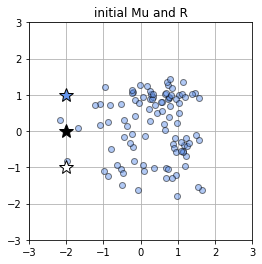

In [23]:
# 데이터를 그리는 함수
def show_prm(x, r, mu, col):
    for k in range(K):
        # 데이터 분포의 묘사
        plt.plot(x[r[:, k] == 1, 0], x[r[:, k] == 1, 1],
                 marker='o',
                 markerfacecolor=X_col[k], markeredgecolor='k',
                 markersize=6, alpha=0.5, linestyle='none')
        # 데이터의 평균을 "별표"로 묘사
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=X_col[k], markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    plt.grid(True)


# 메인
plt.figure(figsize=(4, 4))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

### 9.2.3 Step 1: R의 갱신

* 모든 점에 대해서 cluster의 중심 벡터와 거리가 가장 가까운 cluster를 구해 R을 갱신한다.

* Euclidean distance(L2)를 사용해 거리를 구한다.
    * 실제 거리를 구하기 위해서는 제곱근을 취해야 하지만, 제곱거리가 가까우면 실제 거리도 가깝기 때문에 제곱거리를 통해 비교해도 무방하다.

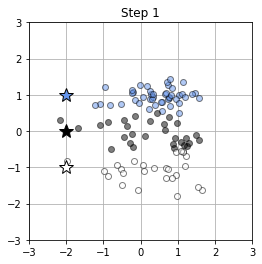

In [24]:
# r을 결정한다 (Step 1)
def step1_kmeans(x0, x1, mu):
    N = len(x0)
    r = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = (x0[n] - mu[k, 0])**2 + (x1[n] - mu[k, 1])**2
        r[n, np.argmin(wk)] = 1
    return r


# 메인
plt.figure(figsize=(4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

### 9.2.4 Step 2: $\mu$의 갱신

* cluster내에 해당되는 모든 점의 각 요소들의 평균으로 $\mu$를 구하게 된다.
$$\mu_{k,0} = \frac{1}{N_k}\sum_{n\,in\,cluster\,K}x_{n0},\;\mu_{k,1} = \frac{1}{N_k}\sum_{n\,in\,cluster\,K}x_{n1}\quad(k = 0,1,2)$$

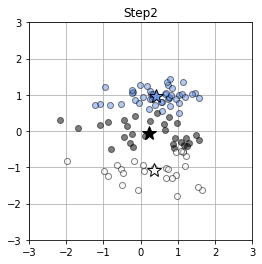

In [25]:
# Mu 결정 (Step 2)
def step2_kmeans(x0, x1, r):
    mu = np.zeros((K, 2))
    for k in range(K):
        mu[k, 0] = np.sum(r[:, k] * x0) / np.sum(r[:, k])
        mu[k, 1] = np.sum(r[:, k] * x1) / np.sum(r[:, k])
    return mu

# 메인
plt.figure(figsize=(4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step2')
plt.show()

* Step 1과 Step 2를 변수의 값이 변화하지 않을 때까지 반복한다.
* 이 예제에서는 6회 반복으로 변화하지 않아서 6회 반복하고 종료했다고 한다.

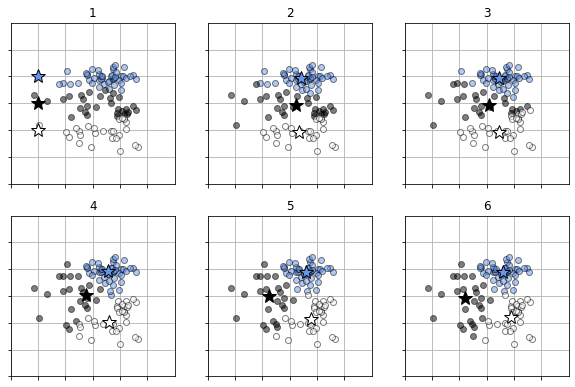

In [26]:
# 메인
plt.figure(1, figsize=(10, 6.5))
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
max_it = 6 # 반복 횟수
for it in range(0, max_it):
    plt.subplot(2, 3, it + 1)
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    show_prm(X, R, Mu, X_col)
    plt.title("{0:d}".format(it + 1))
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "")
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
plt.show()

### 9.2.5 왜곡 척도

* 기존 loss function처럼 최소화가 목적인 함수를 만들 필요가 있다.
* 전체 데이테에서의 데이터 점과 cluster의 중심까지의 제곱거리를 합한 것을 목적 함수로 한다.
    * 이를 왜곡 척도(distortion measure)라고 한다.
$$J = \sum_{n\,in\,cluster\,0}|x_n - \mu_0|^2 + \sum_{n\,in\,cluster\,1}|x_n - \mu_1|^2 + \sum_{n\,in\,cluster\,2}|x_n - \mu_2|^2$$
* 이를 $r_{nk}$를 이용하면 다음과 같다.
$$J = \sum_{n=0}^{N-1}\sum_{k=0}^{K-1}r_{nk}|x_n - \mu_k|^2$$

In [27]:
# 목적 함수
def distortion_measure(x0, x1, r, mu):
    # 입력은 2차원으로 제한하고 있다
    N = len(x0)
    J = 0
    for n in range(N):
        for k in range(K):
            J = J + r[n, k] * ((x0[n] - mu[k, 0])**2
                               + (x1[n] - mu[k, 1])**2)
    return J


# test
# Mu와 R의 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
distortion_measure(X[:, 0], X[:, 1], R, Mu)

771.7091170334878

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


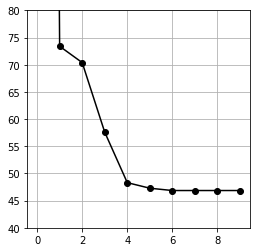

In [28]:
# Mu와 R의 초기화
N=X.shape[0]
K=3
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
max_it = 10
it = 0
DM = np.zeros(max_it) # 왜곡 척도의 계산 결과를 넣는다
for it in range(0, max_it): # K-means 법
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu) # 왜곡 척도
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
print(np.round(DM, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(DM, color='black', linestyle='-', marker='o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

### 참고
* K-means 기법으로 얻은 해는 초기값에 따라 달라진다.
    * 실제로는 여러 $\mu$에서 시작해서 얻은 결과 중 가장 왜곡 척도가 작은 결과를 사용할 수 있다.
* 또한 여기서는 $\mu$를 먼저 정했지만 R을 먼저 정해도 된다.

## 9.3 가우시안 혼합 모델

### 9.3.1 확률적 클러스터링

* K-means 방법은 데이터 점을 반드시 특정한 cluster에 할당한다.
* 하지만 cluster의 경계에 있는 점은 한 cluster에 제한하는 것이 좋지 않을 수 있다.
    * 따라서 확률을 이용해 cluster를 나타내는 방식을 도입한다.
    * 이를 $\gamma_A = [\gamma_{A0}, \gamma_{A1}, \gamma_{A2}]$ 로 나타낼 수 있다.
* 잠재 변수 (latent variable)
    * 관측하진 못했지만 데이터에 영향을 준 변수
    * $z_n = [z_{n0}, z_{n1}, z_{n2}]$
    * R과 거의 유사하지만 잠재 변수라는 것을 강조하기 위해 Z로 표기
    * 데이터 n이 cluster k에 속할 확률 $\gamma_{nk} = P(z_{nk} = 1|x_n)$
        * 이는 관찰할 수 없는 Z의 추정치가 $\gamma$임을 의미한다.
* 부담률 (responsibility)
    * $\gamma$가 어떤 클러스터에 얼마나 기여하고 있는가라는 의미에서 $\gamma$를 부담률이라고도 한다.
    
### 9.3.2 가우시안 혼합 모델

* 부담률 $\gamma$를 구하기 위해 가우시안 혼합 모델을 사용한다.
$$p(x) = \sum_{k=0}^{K-1}\pi_kN(x|\mu_k,\Sigma_k)$$
$$\sum_{k=0}^{K-1}\pi_k = 1$$
* $N(x|\mu_k,\Sigma_k)$는 중심이 $\mu_k$, 공분산 행렬이 $\Sigma_k$인 가우스 함수를 말한다.
* K는 cluster의 개수이며 이 예제에서는 K=3이다.
* $\pi_k$는 각 가우스 분포의 크기의 비율을 나타내며 0과 1사이의 값, 합하면 1이다.


In [31]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [32]:
# 입력 데이터 로드
import numpy as np
wk = np.load('data_ch9.npz')
X = wk['X']
X_range0 = wk['X_range0']
X_range1 = wk['X_range1']

* gauss 함수 정의 후, 데이터 x와 중심 벡터$\mu$와 공분산 행렬 $\Sigma$를 주어진 후 결과를 확인
$$ x: N\times D, \mu: D\times 1, \Sigma: D\times D$$

In [33]:
# 가우스 함수
def gauss(x, mu, sigma):
    N, D = x.shape
    c1 = 1 / (2 * np.pi)**(D / 2)
    c2 = 1 / (np.linalg.det(sigma)**(1 / 2))
    inv_sigma = np.linalg.inv(sigma)
    c3 = x - mu
    c4 = np.dot(c3, inv_sigma)
    c5 = np.zeros(N)
    for d in range(D):
        c5 = c5 + c4[:, d] * c3[:, d]
    p = c1 * c2 * np.exp(-c5 / 2)
    return p

In [34]:
x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


* 다음은 K개의 가우스 함수를 혼합해 만든 혼합 가우시안 모델 함수
* 혼합 계수 $\pi$는 각 가우스 함수가 얼만큼 포함하는지 나타낸다.
* 기존 입력에 혼합 계수 $\pi$를 추가한 후 결과를 확인
$$ x: N\times D, \mu: K\times D, \Sigma: K\times D\times D, \pi: K\times 1$$

In [35]:
# 혼합 가우시안 모델
def mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
    return p

In [36]:
# test
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


* 이를 그래프로 표시

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
# 혼합 가우스 등고선 표시
def show_contour_mixgauss(pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    # 교재에서는 np.reshape(..., 1)로 되어 있는데 이를 np.reshape(..., 'F')로 바꿔야 함
    x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    plt.contour(x0, x1, f, 10, colors='gray')


# 혼합 가우스 3D 표시
def show3d_mixgauss(ax, pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    # 교재에서는 np.reshape(..., 1)로 되어 있는데 이를 np.reshape(..., 'F')로 바꿔야 함
    x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3,
                    color='blue', edgecolor='black')

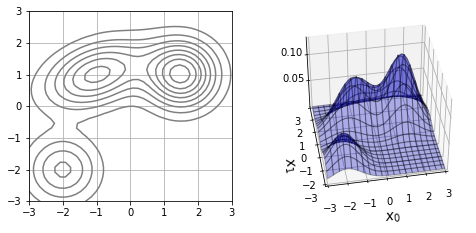

In [45]:
# test
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array(
    [[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])


Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)


Ax = Fig.add_subplot(1, 2, 2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize=14)
Ax.set_ylabel('$x_1$', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

### 9.3.3 EM 알고리즘의 개요

<div>
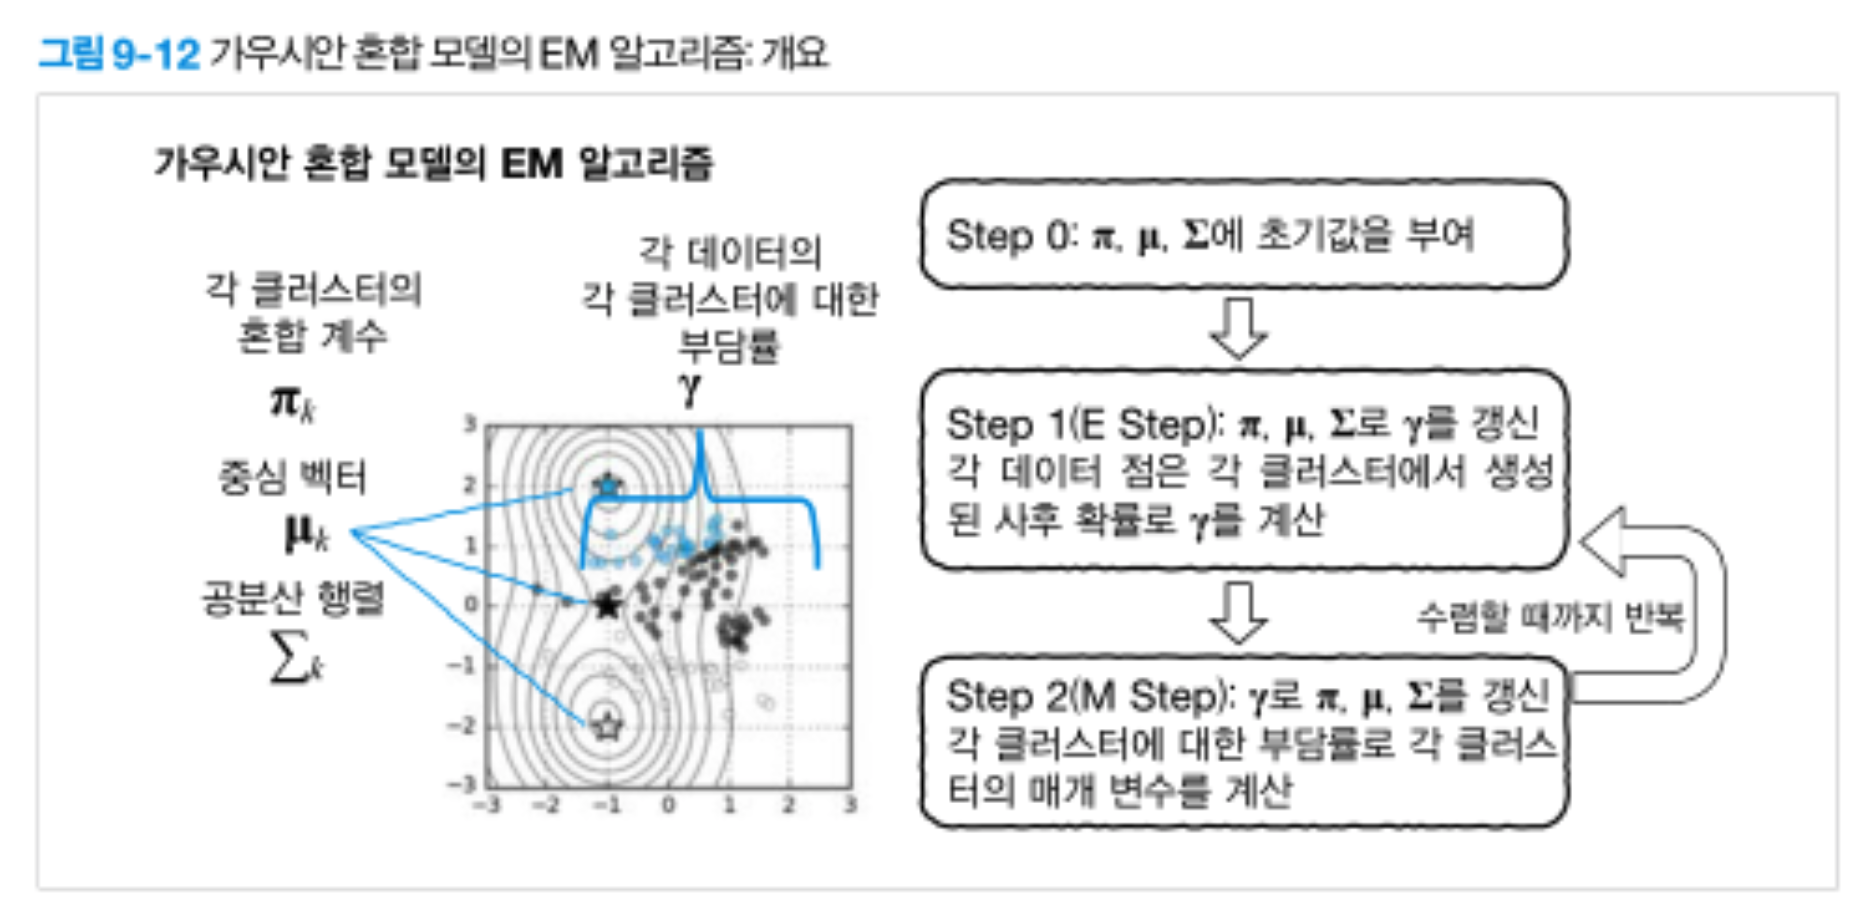
</div>

* K-means에서는 각 cluster의 특징이 $\mu$하나 였지만, 여기서는 공분산 행렬 $\Sigma$, 혼합 계수 $\pi$도 존재한다.
* K-means에서는 데이터 마다 cluster의 값을 1-of-K로 나타낸 R을 출력했지만, 여기서는 각 클래스에 속할 확률인 부담률 $\gamma$를 출력한다.
* Step 1: E(Expectation) Step
    * 현 시점의 $\pi, \mu, \Sigma$를 이용해 $\gamma$를 구하는 것
* Step 2: M(Maximalization) Step
    * 현 시점의 $\gamma$를 이용해 $\pi, \mu, \Sigma$를 구하는 것
* K-means와 마찬가지로 매개변수가 수렴할 때 까지 반복한다.

### 9.3.4 Step 0: 변수의 준비 및 초기화

* 임의의 $\pi, \mu, \Sigma$를 세팅

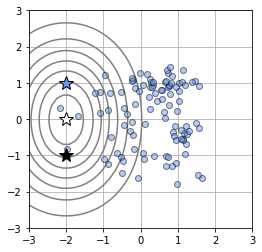

In [46]:
# 초기 설정
N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


X_col=np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])


# 데이터를 그리기
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma)
    for n in range(N):
        col=gamma[n,0]*X_col[0]+gamma[n,1]*X_col[1]+gamma[n,2]*X_col[2]
        plt.plot(x[n, 0], x[n, 1], 'o',
                 color=tuple(col), markeredgecolor='black',
                 markersize=6, alpha=0.5)
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=tuple(X_col[k]), markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
        
        
    plt.grid(True)


plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

### 9.3.5 Step 1(E Step): $\gamma$ 갱신

* 데이터 $x_n$이 있을 경우, K개의 가우스 함수의 출력값을 구하고 이에 대한 비율을 $\gamma$에 대입하는 방식으로 구한다.
* 교재 383p [식9-16]을 보면 다음과 같다
<div>
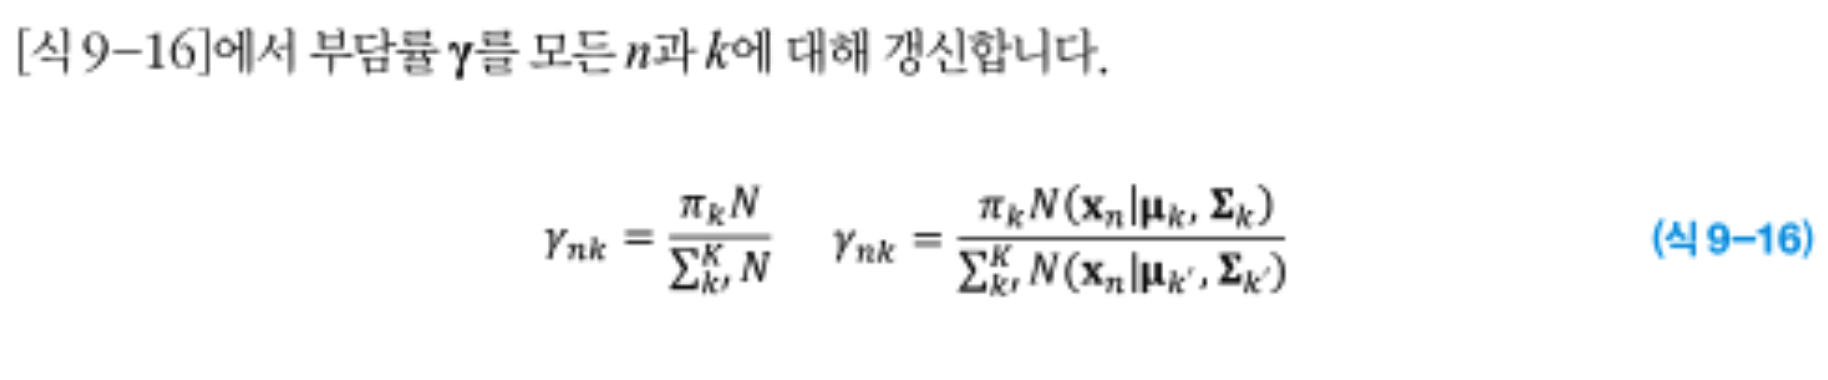
</div>

* $\gamma_{nk}$의 분모를 구할 때 k번째 가우스 함수의 출력값에 $\pi_k$를 곱하지 않는데 잘못된 것으로 추측한다.
* 다음과 같이 K개의 가우스 함수의 출력값의 합을 구할 때 $\pi_k$를 곱해줘야 하지 않나 생각한다.
$$\gamma_{nk} = \frac{\pi_kN(x_n|\mu_k, \Sigma_k)}{\Sigma_{k}^{K}\pi_kN(x_n|\mu_k, \Sigma_k)}$$


In [47]:
# gamma 갱신 (E Step)
def e_step_mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    gamma = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = pi[k] * y[n, k]
        gamma[n, :] = wk / np.sum(wk)
    return gamma


# 메인
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

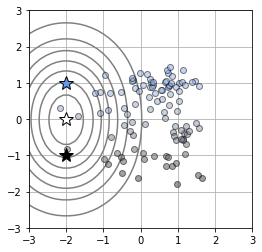

In [48]:
# 표시
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

### 9.3.6 Step 2(M Step): $\pi, \mu, \Sigma$의 갱신

* 우선 각 cluster마다 총 데이터에서의 부담률의 합 $N_k$를 구한다.
$$N_k = \sum_{n=0}^{N-1}\gamma_{nk}$$
* 혼합 계수 $\pi_k$는 다음과 같이 갱신한다.
$$\pi_k^{new} = \frac{N_k}{N}$$
* 중심 벡터 $\mu_k$는 다음과 같이 갱신한다.
$$\mu_k^{new} = \frac{1}{N_k}\sum_{n=0}^{N-1}\gamma_{nk}x_n$$
* 공분산 행렬 $\Sigma_k$는 다음과 같이 갱신한다.
    * 앞에서 구한 $\mu_k^{new}$를 사용한다는 것을 주의한다.
$$\Sigma_k^{new} = \frac{1}{N_k}\sum_{n=0}^{N-1}\gamma_{nk}(x_n - \mu_k^{new})^T(x_n - \mu_k^{new})$$

In [49]:
# Pi, Mu, Sigma 갱신 (M step)
def m_step_mixgauss(x, gamma):
    N, D = x.shape
    N, K = gamma.shape
    # pi를 계산
    pi = np.sum(gamma, axis=0) / N
    # mu을 계산
    mu = np.zeros((K, D))
    for k in range(K):
        for d in range(D):
            mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])
    # sigma를 계산
    sigma = np.zeros((K, D, D))
    for k in range(K):
        for n in range(N):
            wk = x - mu[k, :]
            wk = wk[n, :, np.newaxis]
            sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
        sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])
    return pi, mu, sigma


# 메인
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

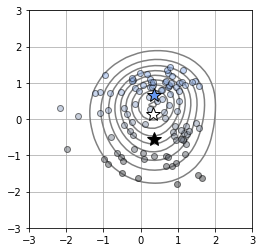

In [50]:
# 표시
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

* E Step과 M Step을 변수들이 변하지 않을 때 까지 반복한다.
* 이 예제에서는 20회 반복하면 변수들이 수렴하여 20회 반복하였다.

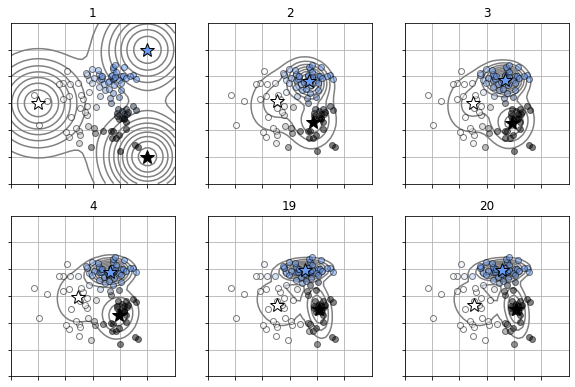

In [51]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize=(10, 6.5))
max_it = 20 # 반복 횟수


i_subplot=1;
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    if it<4 or it>17:
        plt.subplot(2, 3, i_subplot)
        show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
        plt.title("{0:d}".format(it + 1))
        plt.xticks(range(X_range0[0], X_range0[1]), "")
        plt.yticks(range(X_range1[0], X_range1[1]), "")
        i_subplot=i_subplot+1
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)
plt.show()

### 9.3.7 가능도 (likelihood)

* K-means 방법에서는 clustering을 평가하기 위해 왜곡 척도를 사용했지만, 가우시안 혼합 모델에서는 '가능도'를 사용한다.
* 가능도란 입력 X가 가우시안 혼합 모델에서 생성되었다고 했을 때, 입력 X를 생성시키는 확률을 말한다.
    * EM 알고리즘은 가능도를 최대화하는 방향으로 진행된다. -> 최대가능도법 (Maximum likelihood estimation)
    * 오차함수는 가능도에 -log를 취해 구할 수 있다.
    $$E(\pi, \mu, \Sigma) = -\log p(X|\pi, \mu, \Sigma) = -\sum_{n=0}^{N-1}(log\sum_{k=0}^{K-1}\pi_kN(x_n|\mu_k, \Sigma_k))$$

In [52]:
# 혼합 가우스의 목적 함수
def nlh_mixgauss(x, pi, mu, sigma):
    # x: NxD
    # pi: Kx1
    # mu: KxD
    # sigma: KxDxD
    # output lh: NxK
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    lh = 0
    for n in range(N):
        wk = 0
        for k in range(K):
            wk = wk + pi[k] * y[n, k]
        lh = lh + np.log(wk)
    return -lh

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


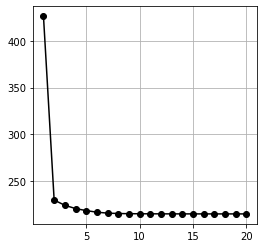

In [53]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


max_it = 20
it = 0
Err = np.zeros(max_it) # distortion measure
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    Err[it] = nlh_mixgauss(X,Pi,Mu,Sigma)
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)


print(np.round(Err, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(np.arange(max_it) + 1,
Err, color='k', linestyle='-', marker='o')
#plt.ylim([40, 80])
plt.grid(True)
plt.show()